In [1]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [4]:
#set color for data visualization
sns.set(rc={"axes.facecolor":"#e6ffed","figure.facecolor":"#e6ffed", "grid.color":"#99e2b4",
            "axes.edgecolor":"#99e2b4", "axes.labelcolor":"#195e2d", "xtick.color":"#195e2d",
            "ytick.color":"#195e2d"})

# ['#4a7c59', '#68b0ab', '#8fc0a9', '#c8d5b9', '#faf3dd']
palettes = ['#eee82c', '#91cb3e', '#53a548', '#4c934c', '#19381f']
cmap = colors.ListedColormap(['#137547', '#2a9134', '#3fa34d', '#5bba6f', '#19381f'])

C:\Users\zhizh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Rating of Replied Reviews')

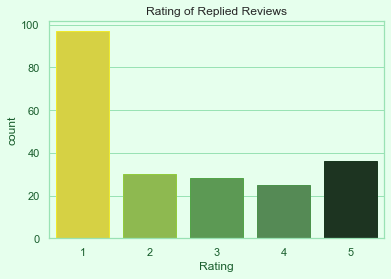

In [5]:
reply = df[~df['Reply'].isna()]

ax = sns.countplot(reply['Rating'], palette=palettes, edgecolor=palettes)
ax.set_title('Rating of Replied Reviews')

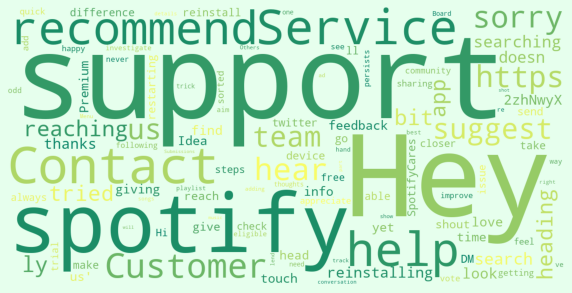

In [6]:
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(reply['Reply']))

plt.axis('off')
plt.imshow(wc)

In [7]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

In [8]:
top_words(reply['Reply'])

Top 5 words that appear most frequently:

support	--> 204
Hey	--> 194
spotify	--> 166
Contact	--> 118
Service	--> 115


In [9]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])

df['Date'] = df['Time_submitted'].apply(lambda x: x.date())

reviews_per_day = df.groupby(df['Date']).count()['Review']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x: x.month)

In [10]:
reviews_per_day.rename(columns={'Review':'Total_review'}, inplace=True)
reviews_per_day.head()

,Date,Total_review,Month
0,2022-01-01,46,1
1,2022-01-02,43,1
2,2022-01-03,66,1
3,2022-01-04,56,1
4,2022-01-05,64,1


Text(0.5, 1.0, 'Total Review per Day')

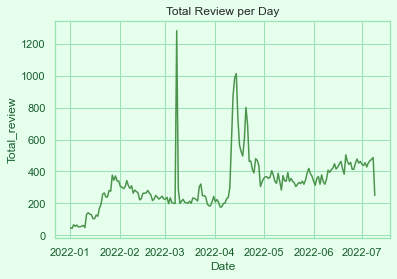

In [11]:
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_review', color='#4c934c')
ax.set_title('Total Review per Day')

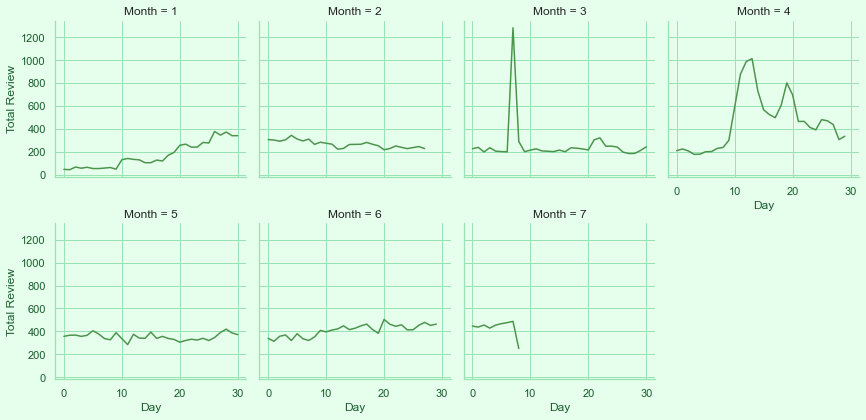

In [12]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4c934c')
g.set_axis_labels(x_var='Day', y_var='Total Review')

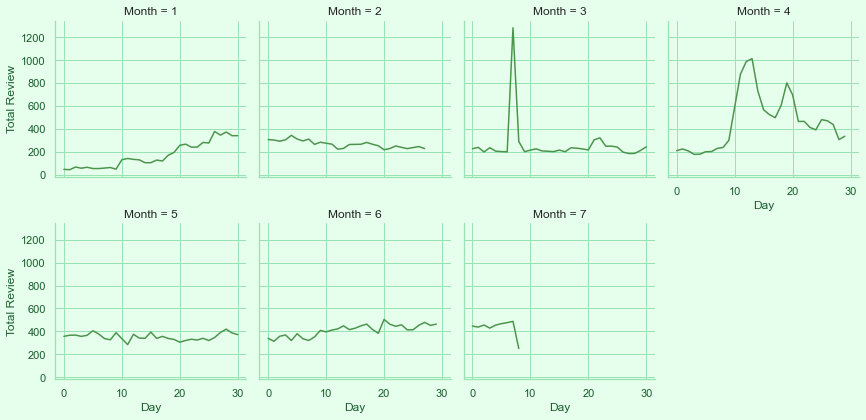

In [13]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4c934c')
g.set_axis_labels(x_var='Day', y_var='Total Review')

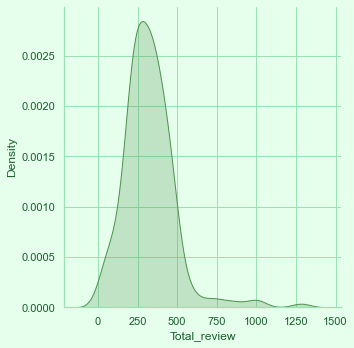

In [14]:
ax = sns.displot(data=reviews_per_day, x='Total_review', kind='kde', fill=True, color='#4c934c')

In [15]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

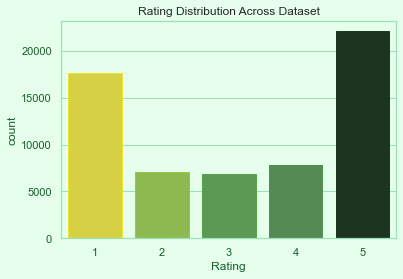

In [16]:
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset')

Text(0.5, 1.0, 'Rating Distribution Across Dataset\nAfter Transformation')

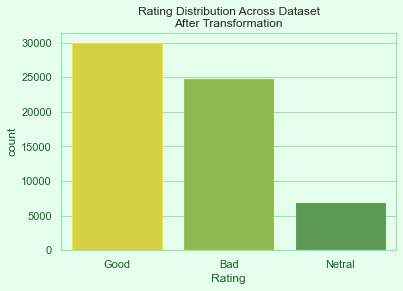

In [17]:
df['Rating'] = df['Rating'].apply(rating)
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset\nAfter Transformation')

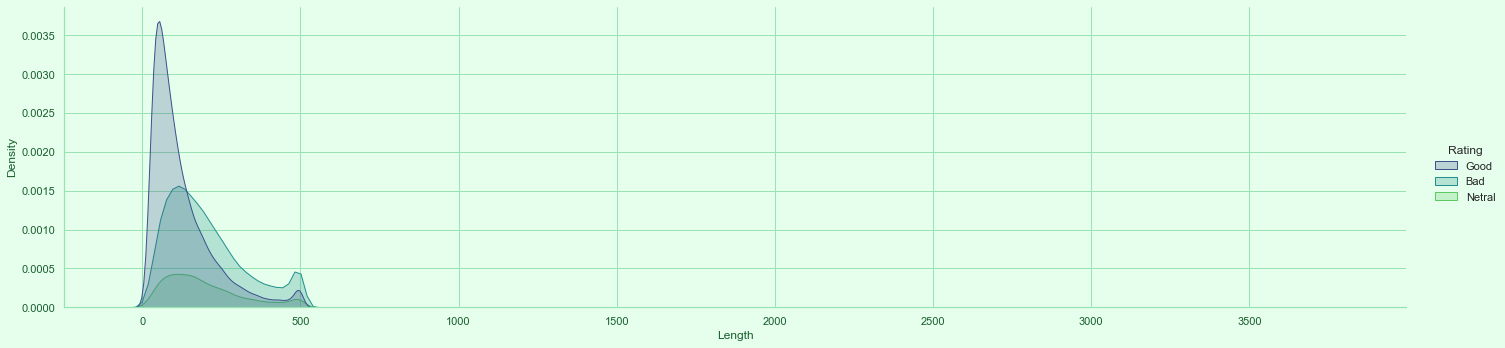

In [18]:
df['Length'] = df['Review'].apply(len)
ax = sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4, palette='viridis')

Text(0.5, 1.0, 'Distribution of review Length\nfor Each Rating')

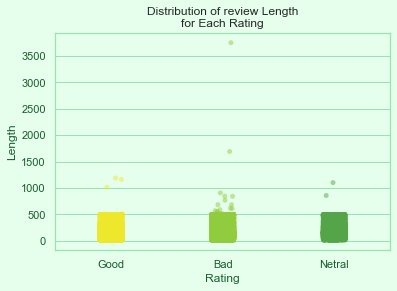

In [19]:
ax = sns.stripplot(data=df, x='Rating', y='Length', alpha=0.5, palette=palettes, edgecolor=palettes)
ax.set_title('Distribution of review Length\nfor Each Rating')

Text(0.5, 1.0, 'Average of review Length\nfor Each Rating')

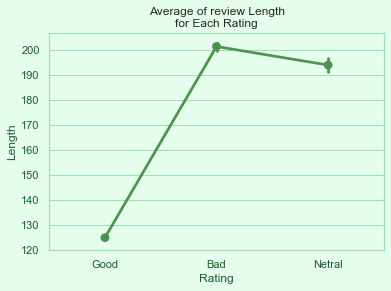

In [20]:
ax = sns.pointplot(data=df, x='Rating', y='Length', color='#4c934c')
ax.set_title('Average of review Length\nfor Each Rating')

In [21]:
max_thumb = df['Total_thumbsup'].max()
print(df[df['Total_thumbsup'] == max_thumb].iloc[0]['Review'])

The app is very good. I got to explore many new songs. However, I took out a star because of a few reasons. First:- It sometimes lags and won't show the music dialog box on your screen or in the app and for this I have to restart it. Second:- I cannot delete my history on phone. Third:- I cannot shuffle playlists or Albums. They have to play on the fixed sequence. Fourth:- I cannot see which song is going to play next if it's a radio and Fifth:- Sometimes the song stops and doesn't start radio


Text(8, -0.2, 'Mean: 7.65')

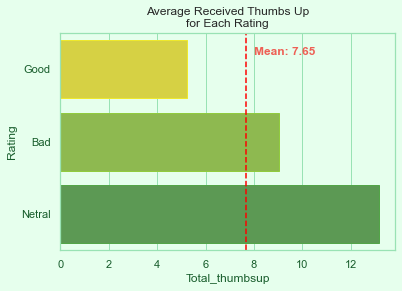

In [22]:
mean_thumb = df['Total_thumbsup'].mean()

ax = sns.barplot(data=df, y='Rating', x='Total_thumbsup', orient='h', ci=None, palette=palettes, edgecolor=palettes)
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='red', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='#ee6055', weight='bold')

Text(0.5, 1.0, 'Distribution of Received Thumbs Up\nfor Each Rating')

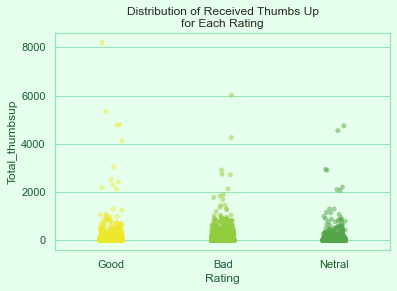

In [23]:
ax = sns.stripplot(data=df, x='Rating', y='Total_thumbsup', palette=palettes, edgecolor=palettes, alpha=0.5)
ax.set_title('Distribution of Received Thumbs Up\nfor Each Rating')

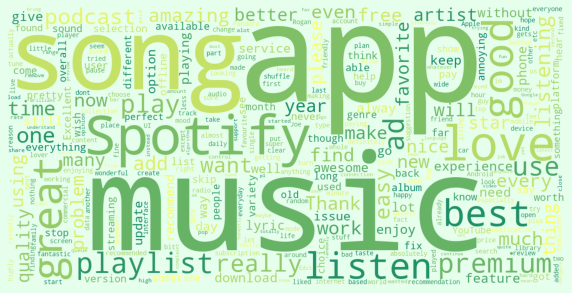

In [24]:
# Most popular word for good review
good = df[df['Rating'] == 'Good']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(good))

plt.axis('off')
plt.imshow(wc)

In [25]:
top_words(good)

Top 5 words that appear most frequently:

app	--> 15681
music	--> 14881
song	--> 10608
Spotify	--> 8621
love	--> 6909


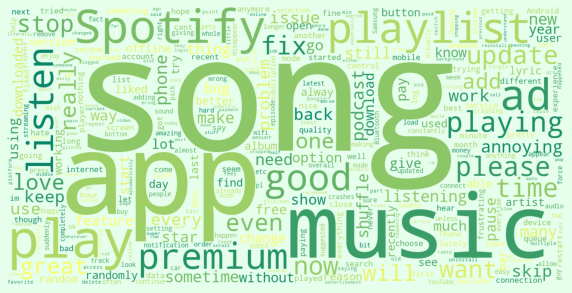

In [26]:
# Most popular word for netral review
netral = df[df['Rating'] == 'Netral']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(netral))

plt.axis('off')
plt.imshow(wc)

In [27]:
top_words(netral)

Top 5 words that appear most frequently:

song	--> 4993
app	--> 4125
music	--> 2322
play	--> 2032
Spotify	--> 1837


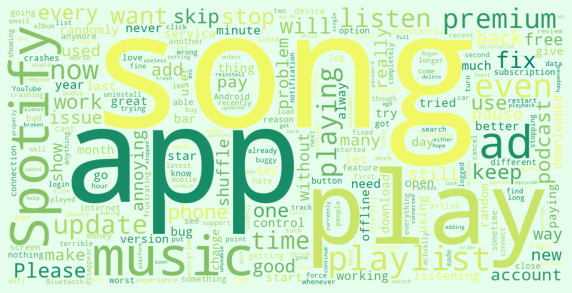

In [28]:
# Most popular word for bad review
bad = df[df['Rating'] == 'Bad']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(bad))

plt.axis('off')
plt.imshow(wc)

In [29]:
top_words(bad)

Top 5 words that appear most frequently:

song	--> 16766
app	--> 16445
play	--> 8867
music	--> 7745
Spotify	--> 7381


In [30]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Date,Length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",Good,2,NaN,2022-07-09,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,Good,1,NaN,2022-07-09,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",Good,0,NaN,2022-07-09,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,Bad,1,NaN,2022-07-09,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,Bad,1,NaN,2022-07-09,100


In [31]:
df_final = df[['Review', 'Rating', 'Length']]

In [32]:
# Total word in dataset before cleaning
length = df_final['Length'].sum()

In [33]:
import nltk
nltk.download('wordnet')

print('Original:')
print(df['Review'][7])
print()

sentence = []
for word in df['Review'][7].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][7].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhizh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original:
Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add "don't like song" so it will never appear again in my searches or playlists.

Stemming:
still extrem slow when chang storag to extern sd card.. i'm convinc this is done on purpose, spotifi know of this issu and has done noth to solv it! over time i have chang sd cards, each be faster in read, write speeds(al samsung brand). and pleas add "don't like song" so it will never appear again in my search or playlists.

Lemmatization:
Still extremely slow when change storage to external sd card.. I'm convince this be do on purpose, spotify know of this issue and have do NOTHING to solve it! Over time I have change sd cards, each be faster in read, write speeds(all samsung brand). And please add "don't like song" 

In [34]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [35]:
nltk.download('stopwords')
df['Review'] = df['Review'].apply(cleaning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhizh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 10059745
Total word after cleaning: 6210516


In [37]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

In [38]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 25596


In [39]:
model_lstm = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word+1, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           204776    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                3200      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 208,555
Trainable params: 208,555
Non-trainable params: 0
__________________________________________________

In [40]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Epoch 1/5
1540/1540 [==============================] - 112s 71ms/step - loss: 0.9777 - accuracy: 0.5407 - val_loss: 0.7947 - val_accuracy: 0.6907
Epoch 2/5
1540/1540 [==============================] - 109s 71ms/step - loss: 0.7559 - accuracy: 0.7136 - val_loss: 0.6445 - val_accuracy: 0.7595
Epoch 3/5
1540/1540 [==============================] - 109s 71ms/step - loss: 0.6771 - accuracy: 0.7584 - val_loss: 0.6192 - val_accuracy: 0.7683
Epoch 4/5
1540/1540 [==============================] - 109s 71ms/step - loss: 0.6504 - accuracy: 0.7734 - val_loss: 0.6083 - val_accuracy: 0.7748
Epoch 5/5
1540/1540 [==============================] - 112s 73ms/step - loss: 0.6300 - accuracy: 0.7855 - val_loss: 0.6049 - val_accuracy: 0.7752


<AxesSubplot:>

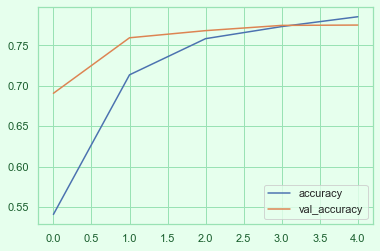

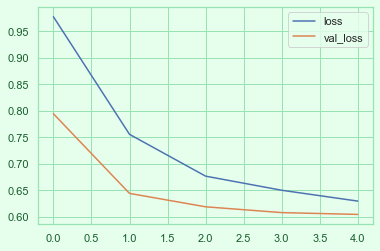

In [41]:
metrics_lstm = pd.DataFrame(model_lstm.history.history)
metrics_lstm[['accuracy', 'val_accuracy']].plot()
metrics_lstm[['loss', 'val_loss']].plot()

In [42]:
model_gru = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word+1, 8),
                                    tf.keras.layers.GRU(8),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           204776    
_________________________________________________________________
gru (GRU)                    (None, 8)                 432       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 205,235
Trainable params: 205,235
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_gru.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Epoch 1/5
1540/1540 [==============================] - 106s 68ms/step - loss: 0.9961 - accuracy: 0.5100 - val_loss: 0.8564 - val_accuracy: 0.6691
Epoch 2/5
1540/1540 [==============================] - 104s 68ms/step - loss: 0.8050 - accuracy: 0.6797 - val_loss: 0.7085 - val_accuracy: 0.7275
Epoch 3/5
1540/1540 [==============================] - 104s 68ms/step - loss: 0.6913 - accuracy: 0.7516 - val_loss: 0.6419 - val_accuracy: 0.7658
Epoch 4/5
1540/1540 [==============================] - 104s 68ms/step - loss: 0.6524 - accuracy: 0.7731 - val_loss: 0.6174 - val_accuracy: 0.7726
Epoch 5/5
1540/1540 [==============================] - 105s 68ms/step - loss: 0.6309 - accuracy: 0.7816 - val_loss: 0.6060 - val_accuracy: 0.7774


<AxesSubplot:>

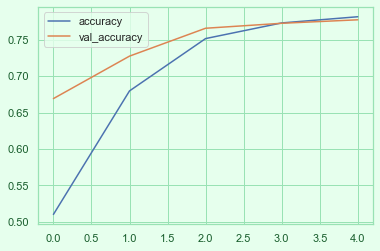

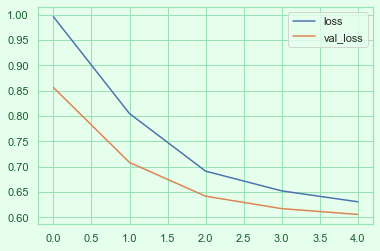

In [44]:
metrics_gru = pd.DataFrame(model_gru.history.history)
metrics_gru[['accuracy', 'val_accuracy']].plot()
metrics_gru[['loss', 'val_loss']].plot()

In [45]:
bert_preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder_url = 'https://tfhub.dev/google/electra_base/2'

bert_preprocess = hub.KerasLayer(bert_preprocess_url)
bert_encoder = hub.KerasLayer(bert_encoder_url)

In [46]:
# Example
def bert_example(sentence):
    preprocessed_text = bert_preprocess(sentence)
    return bert_encoder(preprocessed_text)['pooled_output']

In [47]:
exp = bert_example(['cat', 'dog', 'eye', 'nose'])

from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([exp[0]], [exp[1]])) # flower and vegetable
print(cosine_similarity([exp[0]], [exp[2]])) # flower and eye
print(cosine_similarity([exp[2]], [exp[3]])) # eye and nose

[[0.60661554]]
[[0.31586167]]
[[0.51162976]]


In [48]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

# DNN
x = tf.keras.layers.Dropout(0.2)(output['pooled_output'])
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Build the model
model_bert = tf.keras.Model(text_input, x)

In [49]:
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [51]:
model_bert.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                   metrics=['accuracy'])

model_bert.fit(X_train, train_labels, epochs=5, batch_size=32, validation_data=(X_test, test_labels))

Epoch 1/5
 251/1540 [===>..........................] - ETA: 1:09:31 - loss: 0.7748 - accuracy: 0.6795

KeyboardInterrupt: 

In [ ]:
metrics_bert = pd.DataFrame(model_bert.history.history)
metrics_bert[['accuracy', 'val_accuracy']].plot()
metrics_bert[['loss', 'val_loss']].plot()

In [ ]:
def lstm_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_lstm.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def gru_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_gru.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def bert_prediction(text):
    clean_text = cleaning(text)
    
    pred = model_bert.predict([clean_text])
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [ ]:
text1 = "There is a major bug in the app. I can't play my playlist since the last 2 days"

print('LSTM\t: ', lstm_prediction(text1))
print('GRU\t: ', gru_prediction(text1))
print('BERT\t: ', bert_prediction(text1))

In [ ]:
text2 = "Love this app! the interface is clean and pleasing to the eye"

print('LSTM\t: ', lstm_prediction(text2))
print('GRU\t: ', gru_prediction(text2))
print('BERT\t: ', bert_prediction(text2))

In [ ]:
text3 = "The overall experience is good, but the ads really annoying"

print('LSTM\t: ', lstm_prediction(text3))
print('GRU\t: ', gru_prediction(text3))
print('BERT\t: ', bert_prediction(text3))